https://colab.research.google.com/github/fastai/fastbook/blob/master/02_production.ipynb#scrollTo=cNzVuQIQUsQX

# From Model to Production

In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *



In [3]:
!pip install -Uqq duckduckgo_search


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 32.0 MB/s eta 0:00:00


## Step 1: Download images of bears and non-bears

In [4]:
from itertools import islice
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    # DDGS().images return an interator containing all images found
    # we use islice to limit the number of results returned
    return L(islice(DDGS().images(term), max_images)).itemgot('image')

Let's start by searching for a bear photo and seeing what kind of result we get. We'll start by getting URLs from a search:


In [5]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('grizzly', max_images=1)
urls[0]


Searching for 'grizzly'


'https://www.wallpics.net/wp-content/uploads/2020/12/Grizzly-Bear-10.jpg'

Download a URL and take a look at it:

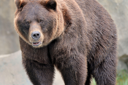

In [6]:
from fastdownload import download_url
dest = 'images/grizzly.jpg'
download_url(urls[0], dest, show_progress=True)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(128,128)

In [10]:
#from google.colab import files
#import os
#print(os.getcwd())
#os.listdir('/content/images')
#image_path = '/content/images/grizzly.jpg'  # Replace with your image path
#files.download(image_path)


/content


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')
#for o in bear_types:
#    dest = (path/o)
#    dest.mkdir(exist_ok=True, parents=True)
#    results=search_images(f'{o} bear')
#    download_images(dest, urls=results)
    #resize_images(path/o, max_size=400, dest=path/o)

if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))


In [16]:
fns = get_image_files(path)
len(fns)


79

## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [17]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

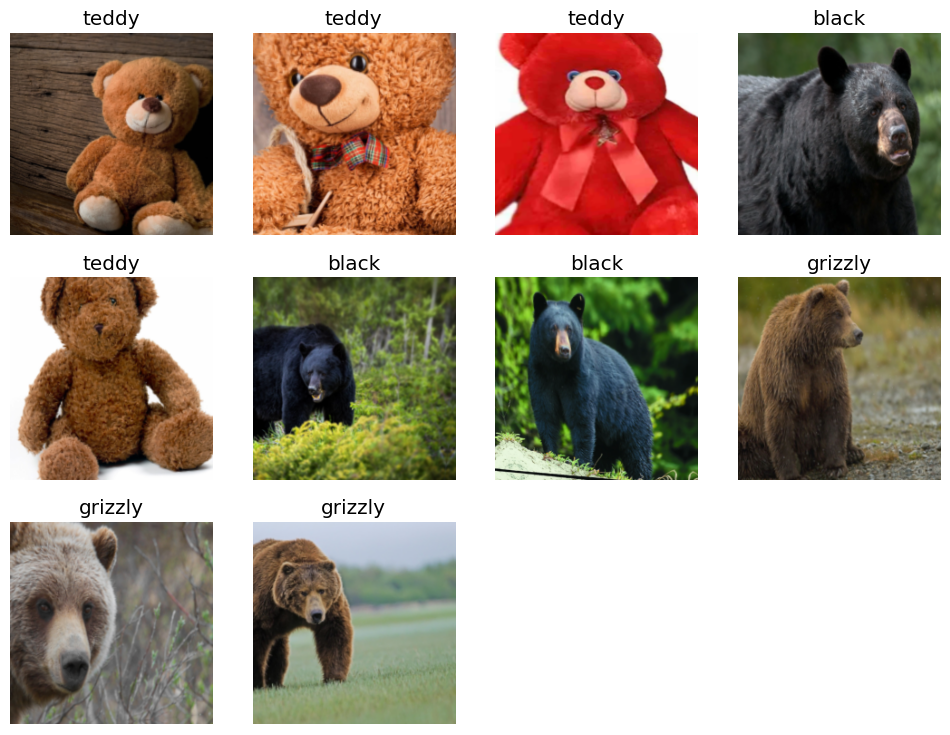

In [18]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    #item_tfms=[Resize(192, method='squish')]
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
).dataloaders(path, bs=32)

bears.show_batch(max_n=10)

In [19]:
learn = vision_learner(bears, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 58.5MB/s]


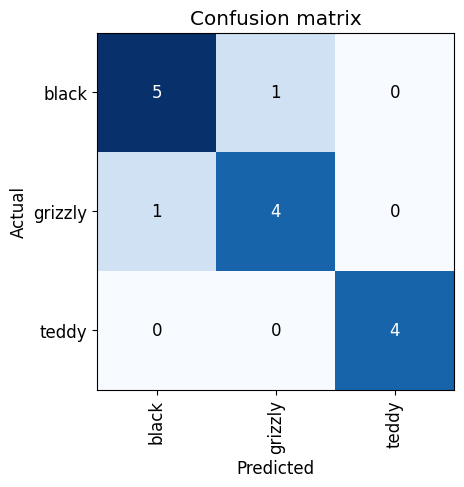

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Now let's see whether the mistakes the model is making are mainly thinking that grizzlies are teddies (that would be bad for safety!), or that grizzlies are black bears, or something else. To visualize this, we can create a *confusion matrix*.

The rows represent all the black, grizzly, and teddy bears in our dataset, respectively. The columns represent the images which the model predicted as black, grizzly, and teddy bears, respectively. Therefore, the diagonal of the matrix shows the images which were classified correctly, and the off-diagonal cells represent those which were classified incorrectly. This is one of the many ways that fastai allows you to view the results of your model. It is (of course!) calculated using the validation set. With the color-coding, the goal is to have white everywhere except the diagonal, where we want dark blue. Our bear classifier isn't making many mistakes!

It's helpful to see where exactly our errors are occurring, to see whether they're due to a dataset problem (e.g., images that aren't bears at all, or are labeled incorrectly, etc.), or a model problem (perhaps it isn't handling images taken with unusual lighting, or from a different angle, etc.). To do this, we can sort our images by their *loss*.

The loss is a number that is higher if the model is incorrect (especially if it's also confident of its incorrect answer), or if it's correct, but not confident of its correct answer. `plot_top_losses` shows us the images with the highest loss in our dataset. As the title of the output says, each image is labeled with four things: prediction, actual (target label), loss, and probability. The *probability* here is the confidence level, from zero to one, that the model has assigned to its prediction:

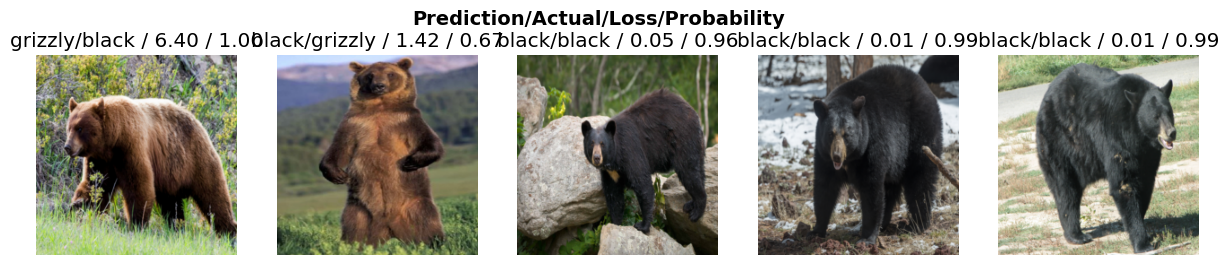

In [21]:
interp.plot_top_losses(5, nrows=1)

In [22]:
from fastai.vision.widgets import ImageClassifierCleaner

doc(ImageClassifierCleaner)

ImageClassifierCleaner(learn, *, opts: 'tuple' = (), height: 'int' = 128, width: 'int' = 256, max_n: 'int' = 30)
A widget that provides an `ImagesCleaner` for a CNN `Learner`

To get a prettier result with hyperlinks to source code and documentation, install nbdev: pip install nbdev


In [23]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

ImageClassifierCleaner doesn't actually do the deleting or changing of labels for you; it just returns the indices of items to change. So, for instance, to delete (unlink) all images selected for deletion, we would run:

In [24]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()


To move images for which we've selected a different category, we would run:

In [25]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)


## Step 3: Turn model into online application

Once you've got a model you're happy with, you need to save it, so that you can then copy it over to a server where you'll use it in production. Remember that a model consists of two parts: the architecture and the trained parameters. The easiest way to save the model is to save both of these, because that way when you load a model you can be sure that you have the matching architecture and parameters. To save both parts, use the export method.



In [27]:
learn.export()

In [28]:
path=Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [29]:
#from google.colab import files
#from pathlib import Path

# Create a Path object to the current directory
#path = Path()

# List the files with .pkl extension
#pkl_files = path.ls(file_exts='.pkl')

# Check if the file exists and download it
#if pkl_files:
    # Get the first .pkl file found
#    file_to_download = pkl_files[0]

    # Download the file
 #   files.download(file_to_download)
#else:
#    print("No .pkl files found.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

You'll need this file wherever you deploy your app to. For now, let's try to create a simple app within our notebook.


In [30]:
learn_inf=load_learner(path/'export.pkl')

In [32]:
learn_inf.predict('images/grizzly.jpg')


('grizzly', tensor(1), tensor([1.7303e-02, 9.8269e-01, 6.8253e-06]))

This has returned three things: the predicted category in the same format you originally provided (in this case that's a string), the index of the predicted category, and the probabilities of each category. The last two are based on the order of categories in the *vocab* of the `DataLoaders`; that is, the stored list of all possible categories. At inference time, you can access the `DataLoaders` as an attribute of the `Learner`:

In [33]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

### Step 4: Creating a Notebook App from the Model

We can create a complete working web application using nothing but Jupyter notebooks! The two things we need to make this happen are:

- IPython widgets (ipywidgets)
- Voilà

*IPython widgets* are GUI components that bring together JavaScript and Python functionality in a web browser, and can be created and used within a Jupyter notebook. For instance, the image cleaner that we saw earlier in this chapter is entirely written with IPython widgets. However, we don't want to require users of our application to run Jupyter themselves.

That is why *Voilà* exists. It is a system for making applications consisting of IPython widgets available to end users, without them having to use Jupyter at all. Voilà is taking advantage of the fact that a notebook _already is_ a kind of web application, just a rather complex one that depends on another web application: Jupyter itself. Essentially, it helps us automatically convert the complex web application we've already implicitly made (the notebook) into a simpler, easier-to-deploy web application, which functions like a normal web application rather than like a notebook.

But we still have the advantage of developing in a notebook, so with ipywidgets, we can build up our GUI step by step. We will use this approach to create a simple image classifier. First, we need a file upload widget:

In [34]:
#hide_output
btn_upload=widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [36]:
#hide
btn_upload=SimpleNamespace(data=['images/grizzly.jpg'])

In [37]:
img=PILImage.create(btn_upload.data[-1])

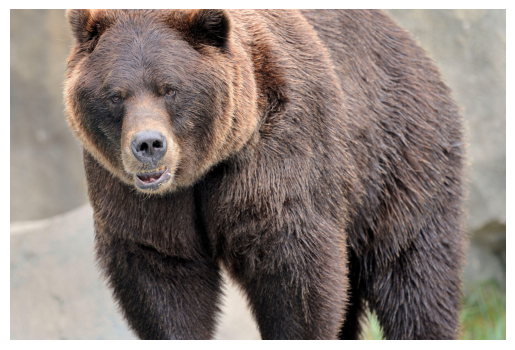

In [38]:
# Display the image using matplotlib
plt.imshow(img)
plt.axis('off')  # Hide axes for cleaner display
plt.show()


Use `Output` widget to disply it:

In [39]:
#hide_output
out_pl=widgets.Output()
out_pl.clear_output()
with out_pl:display(img.to_thumb(128,128))
out_pl

Output()

We can get predictions:

In [40]:
pred,pred_idx,probs=learn_inf.predict(img)

and use a `Label` to display them:

In [41]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 0.9827')

we will need a button to do the classification. It looks like the upload button.

In [42]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run


Button(description='Classify', style=ButtonStyle())

we also need a `click event handler`, that is, a function that will be when it is pressed. We just copy over the lines from above:

In [43]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)


In [44]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()


You can test the button now by pressing it, and you should see the image and predictions update automatically!

We can now put them all in a vertical box (`VBox`) to complete our GUI:

In [45]:
#hide_output
VBox([widgets.Label('Select your bear!'),
      btn_upload, btn_run, out_pl, lbl_pred])


The next step is to convert it into something we can deploy.

